## create_datasets를 먼저 돌리고 실행

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas_datareader as pdr 
import FinanceDataReader as fdr

# Fama - French 5요인
- 참고 논문: http://kiss.kstudy.com/thesis/thesis-view.asp?key=3450399

## Size 요소 가져오기

In [2]:
idx = pd.IndexSlice

In [3]:
stock_data = pd.read_hdf('assets.h5', 'finance_datareader/prices')
market_cap_rank_data = stock_data[['adj_marcap', 'rank']]

In [4]:
total_asset = pd.read_csv('IFRS/TotalAssets.csv', encoding='CP949')

In [5]:
# 종목코드를 6자리로 맞춰줌 -> 파이썬 고질병 '000660'을 숫자로 자동 인식하면 앞의 000을 날려버림 이거를 string으로 변경해서 복구
ticker = total_asset['거래소코드'].apply("{0:0>6}".format)

In [6]:
# 금융업 제외한 재무제표랑 market cap 데이터랑 겹치는 종목 추출
intersect_ticker = market_cap_rank_data.unstack('date').index.intersection(ticker)

In [7]:
size_factor = (market_cap_rank_data
                .unstack('date')
                .loc[intersect_ticker,:].stack('date')
                .reorder_levels(['date','ticker'])
                .sort_index())

In [8]:
size_factor = size_factor.astype('float64')

In [9]:
# 월별로 시가총액 순위를 구하고 6월달 시가총액 순위만 출력
month_rank = size_factor['adj_marcap'].unstack('ticker').resample('M').last().rank(axis=1)
six_month_rank = month_rank[month_rank.index.month == 6].stack('ticker').to_frame()
six_month_rank = six_month_rank.rename(columns={0:'rank'})
six_month_rank = six_month_rank.astype('int32')

In [10]:
# Monthly Period로 변경
six_month_rank.index = six_month_rank.index.set_levels(six_month_rank.index.levels[0].to_period('M'), level=0)

In [11]:
# 일자별 시가총액 순위 데이터
size_factor.head(5)

,,adj_marcap,rank
date,ticker,,
1997-04-21,005190,NaN,164.0
1997-04-22,005190,NaN,164.0
1997-04-23,005190,NaN,166.0
1997-04-24,005190,NaN,164.0
1997-04-25,005190,NaN,165.0


In [12]:
six_month_rank.head(5)

rank
date    ticker      
1997-06 000020   218
        000040   365
        000050   169
        000070   213
        000100   229

## B/M Book to Market Ratio 구하기
- 시가총액은 연도 말을 기준으로 한다.
- 재무제표는 사업보고서이고 공시 날짜는 6월 1일로 통일한다.

In [13]:
def get_ifrs_data(data_path: str):
    data = pd.read_csv(data_path, encoding='CP949')
    data.fillna(0, inplace=True)
    data['거래소코드'] = data['거래소코드'].apply("{0:0>6}".format)
    data['회계년도'] = pd.to_datetime(data['회계년도'])
    data = data.set_index(['회계년도','거래소코드']).sort_index()
    # 회계년도 안맞는 것들 resample을 이용해 연말로 회계년도 통일
    data = data.unstack('거래소코드').resample('Y').last().stack('거래소코드')
    data.index = data.index.set_levels(data.index.levels[0].to_period('M'), level=0)
    col_list = data.columns
    
    # 2007년 부터 IFRS 회계방식 도입으로 그전 년도에는 전 회계기준을 적용
    before_ifrs = data.loc[idx[:'2006',:],:][col_list[-2]]
    after_ifrs = data.loc[idx['2007':,:],:][col_list[-1]]
    data = pd.concat([before_ifrs, after_ifrs]).to_frame()
    data.columns = [col_list[-2]]
    data.index.names = ['date','ticker']
    data.sort_index(inplace=True)
    return data.copy()

In [14]:
idx = pd.IndexSlice

In [15]:
common_stock_capital = get_ifrs_data('IFRS/CommonStock.csv')

In [16]:
common_stock_capital

보통주자본금(천원)
date    ticker             
1981-12 000020    2808000.0
        000040    3450000.0
        000050    2400000.0
        000070    9500000.0
        000080    3000000.0
...                     ...
2020-12 363280   18750451.0
        375500          0.0
        378850          0.0
        900140          0.0
        950210  152779419.0

[20876 rows x 1 columns]

In [17]:
capital_surplus = get_ifrs_data('IFRS/CapitalSurplus.csv')

In [18]:
capital_surplus

자본잉여금(*)(천원)
date    ticker              
1981-12 000020        4410.0
        000040     1903860.0
        000050    12797820.0
        000070     9538010.0
        000080     8837667.0
...                      ...
2020-12 363280   528596133.0
        375500           0.0
        378850           0.0
        900140           0.0
        950210           0.0

[20876 rows x 1 columns]

In [19]:
retained_earnings = get_ifrs_data('IFRS/RetainedEarnings.csv')

In [20]:
retained_earnings

이익잉여금(*)(천원)
date    ticker              
1981-12 000020     2567147.0
        000040      343796.0
        000050           0.0
        000070     6452616.0
        000080     1002994.0
...                      ...
2020-12 363280    -2390485.0
        375500           0.0
        378850           0.0
        900140           0.0
        950210   -21560969.0

[20876 rows x 1 columns]

In [21]:
deferred_tax_liabilities = get_ifrs_data('IFRS/DeferredTaxLiabilities.csv')

In [22]:
market_cap_data = stock_data['adj_marcap'].to_frame()

In [23]:
market_cap_data = market_cap_data.unstack('ticker').resample('Y').last().stack('ticker')

In [24]:
market_cap_data.index = market_cap_data.index.set_levels(market_cap_data.index.levels[0].to_period('M'), level=0)

In [25]:
market_cap_data

adj_marcap
date    ticker              
1997-12 000020  2.681421e+10
        000040  7.742135e+12
        000050  3.437875e+10
        000060  9.396688e+10
        000070  5.604459e+10
...                      ...
2021-12 378850  1.194699e+11
        380440  1.077090e+11
        383220  3.160334e+12
        900140  3.540609e+11
        950210  1.730769e+12

[14735 rows x 1 columns]

In [26]:
book_to_market_data = pd.concat([common_stock_capital, capital_surplus, retained_earnings, deferred_tax_liabilities, market_cap_data], axis=1)
book_to_market_data.sort_index(inplace=True)

In [27]:
book_to_market_data

보통주자본금(천원)  자본잉여금(*)(천원)  이익잉여금(*)(천원)  이연법인세부채(천원)  \
date    ticker                                                        
1981-12 000020   2808000.0        4410.0     2567147.0          0.0   
        000040   3450000.0     1903860.0      343796.0          0.0   
        000050   2400000.0    12797820.0           0.0          0.0   
        000070   9500000.0     9538010.0     6452616.0          0.0   
        000080   3000000.0     8837667.0     1002994.0          0.0   
...                    ...           ...           ...          ...   
2021-12 378850         NaN           NaN           NaN          NaN   
        380440         NaN           NaN           NaN          NaN   
        383220         NaN           NaN           NaN          NaN   
        900140         NaN           NaN           NaN          NaN   
        950210         NaN           NaN           NaN          NaN   

                  adj_marcap  
date    ticker                
1981-12 000020           NaN  
        000040           NaN  
        000050           NaN  
        000070           NaN  
        000080           NaN  
...                      ...  
2021-12 378850  1.194699e+11  
        380440  1.077090e+11  
        383220  3.160334e+12  
        900140  3.540609e+11  
        950210  1.730769e+12  

[22669 rows x 5 columns]

In [28]:
# 시가총액이 있는 년도부터 시작
book_to_market_data = book_to_market_data.loc[idx['1995':'2021',:],:]

In [29]:
# 결측치 제거
book_to_market_data.dropna(inplace=True)

<ipython-input-29-f2b34a7bd11a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_to_market_data.dropna(inplace=True)


### Book to Market Ratio 구하기

In [30]:
# B/M 계산
columns_list = book_to_market_data.columns
book_value = book_to_market_data.loc[:,columns_list[:-1]].sum(axis=1)
book_to_market_ratio = book_value.div(book_to_market_data['adj_marcap']).to_frame()
book_to_market_ratio.columns = ['BM']


### 회계년도랑 공시년도가 차이가 나므로 회계년도에서 6개월 뒤로 미룬다.
- 년말 12월 기준의 회계가 있어도 공시하기까지 시간이 걸린다. 이부분을 고려

In [31]:
def offset_6_month(data: pd.DataFrame) -> pd.DataFrame:
    '''
        Input DataFrame E.g
        Multi Index DataFrame
                      price
        date  ticker
     1995-12  000660  1000
              005930  20000
              003229  3004000
              
        
        Output DataFrame E.g
                         price
        date  ticker
     1996-06  000660  1000
              005930  20000
              003229  3004000
        
    '''
    date_index = data.index.levels[0].to_timestamp() + pd.DateOffset(months=6)
    data.index = data.index.set_levels(date_index.to_period('M'), level=0)
    return data 

## B/M Ratio 공시날짜를 위해서 6개월 미루기

In [32]:
book_to_market_ratio = offset_6_month(book_to_market_ratio)

In [33]:
book_to_market_ratio

BM
date    ticker          
1998-06 000020  0.001857
        000040  0.000008
        000050  0.001659
        000070  0.003725
        000100  0.001435
...                  ...
2021-06 344820  0.002336
        352820  0.000214
        353200  0.001031
        363280  0.000501
        900140  0.000000

[12942 rows x 1 columns]

## 수익성 지표 계산
- OP = 영업이익 / 자기자본 장부가치
    + 영업이익 = 매출액 - 매출원가 - 이자비용 - 판관비

#### 매출액

In [34]:
net_sales = get_ifrs_data('IFRS/NetSales.csv')

In [35]:
net_sales

매출액(영업수익)(*)(천원)
date    ticker                  
1981-12 000020        26964281.0
        000040        48075570.0
        000050        52868914.0
        000070       223628100.0
        000080        93182984.0
...                          ...
2020-12 363280               0.0
        375500               0.0
        378850               0.0
        900140               0.0
        950210               0.0

[20876 rows x 1 columns]

#### 매출원가

In [36]:
cost_of_sales = get_ifrs_data('IFRS/CostOfSales.csv')

In [37]:
cost_of_sales

매출원가(*)(천원)
date    ticker             
1981-12 000020   16814161.0
        000040   42802676.0
        000050   46724109.0
        000070  189372232.0
        000080   75451679.0
...                     ...
2020-12 363280          0.0
        375500          0.0
        378850          0.0
        900140          0.0
        950210          0.0

[20876 rows x 1 columns]

#### 이자비용

In [38]:
interest_expense = get_ifrs_data('IFRS/InterestExpenses.csv')

In [39]:
interest_expense

이자비용(천원)
date    ticker          
1981-12 000020       0.0
        000040       0.0
        000050       0.0
        000070       0.0
        000080       0.0
...                  ...
2020-12 363280       0.0
        375500       0.0
        378850       0.0
        900140       0.0
        950210       0.0

[20876 rows x 1 columns]

### 판매비와 관리비

In [40]:
selling_and_admin_expense = get_ifrs_data('IFRS/Selling_and_administrative_expenses.csv')

In [41]:
selling_and_admin_expense

판매비와관리비(영업비용)(*)(천원)
date    ticker                      
1981-12 000020             6385484.0
        000040             2264367.0
        000050             2939748.0
        000070            10461231.0
        000080            11557635.0
...                              ...
2020-12 363280             2265873.0
        375500                   0.0
        378850                   0.0
        900140                   0.0
        950210            10708804.0

[20876 rows x 1 columns]

In [42]:
op_data = pd.concat([net_sales, cost_of_sales, interest_expense, selling_and_admin_expense], axis=1)

In [43]:
op_data.head(5)

매출액(영업수익)(*)(천원)  매출원가(*)(천원)  이자비용(천원)  판매비와관리비(영업비용)(*)(천원)
date    ticker                                                               
1981-12 000020        26964281.0   16814161.0       0.0             6385484.0
        000040        48075570.0   42802676.0       0.0             2264367.0
        000050        52868914.0   46724109.0       0.0             2939748.0
        000070       223628100.0  189372232.0       0.0            10461231.0
        000080        93182984.0   75451679.0       0.0            11557635.0

In [44]:
col_list = op_data.columns

In [45]:
# 위의 식대로 계산
op = (op_data[col_list[0]] - op_data[col_list[1:]].sum(axis=1)).div(book_value).to_frame()

In [46]:
op.columns = ['OP']
op.dropna(inplace=True)

In [47]:
op = offset_6_month(op)

In [48]:
op 

OP
date    ticker          
1998-06 000020  0.436609
        000040  0.083735
        000050  0.293923
        000070  0.196609
        000100  0.091484
...                  ...
2021-06 339770  0.198420
        344820  0.026108
        352820  0.071987
        353200  0.018592
        363280 -0.004065

[12903 rows x 1 columns]

## 자본투자
- t-1년 12월 말의 총자산에서 t-2년 12월 말의 총 자산을 차감한 총자산증가액
    + inv = TotalAsset(t-1) / TotalAsset(t-2) - 1

### 총 자산

In [49]:
total_asset = get_ifrs_data('IFRS/TotalAssets.csv')

In [50]:
total_asset_unstack = total_asset.unstack('ticker')

In [51]:
inv = (total_asset_unstack / total_asset_unstack.shift(1)).stack('ticker') - 1

In [52]:
inv = offset_6_month(inv)

In [53]:
inv.columns = ["INV"]

In [54]:
inv

INV
date    ticker          
1983-06 000040  0.150404
        000050  0.033943
        000100  0.524996
        000120  0.108065
        000140  0.154147
...                  ...
2021-06 336260  0.593889
        336370  0.508118
        339770  0.519012
        352820  5.267460
        361610  1.137762

[19811 rows x 1 columns]

## Size-B/M, Size-OP, Size-Inv Portfolio 구성
- 가격 데이터가 1995년부터 있으므로 1995년부터 Portfolio 구성
- Value weight portfolio

기업규모
- 하위 50%, 상위 50%


B/M
- 상위 33%, 중위 33%, 하위 33%


수익성
- 상위 33%, 중위 33%, 하위 33%


자본투자
- 하위 33%, 중위 33%, 상위 33%

#### Size - B/M 포트폴리오
|Size/ BM|Small|Big|
|---|---|---|
|High BM|SH|BH|
|2|SN|BN|
|Low BM|SL|BL|

#### Size - OP 포트폴리오
|Size/ OP|Small|Big|
|---|---|---|
|High OP|SR|BR|
|2|SN|BN|
|Low OP|SW|BW|

#### Size - Inv 포트폴리오
|Size/ Inv|Small|Big|
|---|---|---|
|High Inv|SC|BC|
|2|SN|BN|
|Low Inv|SA|BA|

### Equal Weight Portfolio로 구성 

#### SMB 구하기
- 2분위수로 Size Factor로 나누고 이에 따라서

In [55]:
# 시간 인덱스 가져오기
period_index = book_to_market_ratio.unstack('ticker').index

### 수정 수익률 데이터 구하기

In [56]:
# 시가총액의 증감으로 수익률 구하기
return_data = (stock_data[['adj_close']]
                                .unstack('ticker')
                                .fillna(method='bfill')
                                .fillna(0)
                                .resample('M')
                                .last()
                                .pct_change()
                                .mul(100)
                                .stack('ticker')
                                
              )

In [57]:
return_data.columns = ['return']

In [58]:
return_data.index = return_data.index.set_levels(return_data.index.levels[0].to_period('M'), level=0)

In [59]:
return_data

return
date    ticker           
1995-06 000020   0.000000
        000040   0.000000
        000050   0.000000
        000060   0.000000
        000070   0.000000
...                   ...
2021-05 378850  -1.564945
        380440   0.000000
        383220   0.000000
        900140  -2.864939
        950210 -14.918759

[249602 rows x 1 columns]

### 1년 Size - B/M Portfolio 수익률 먼저 만들어 보기

In [60]:
# 처음 월들을 기준으로 정하기
first_month = period_index[0]
print(first_month)

1998-06


In [61]:
rank = six_month_rank.loc[idx[first_month,:],:]['rank']

In [62]:
rank

date     ticker
1998-06  000020    198
         000040    355
         000050    175
         000070    195
         000100    280
                  ... 
         029460    186
         029530    326
         030000    273
         030720     43
         031820    266
Name: rank, Length: 391, dtype: int32

#### 2분위수로 Size Factor 나누기
- Size를 먼저

In [63]:
rank_qauntile = pd.qcut(rank, q=2, labels=['small','big']).to_frame()

In [64]:
rank_qauntile

rank
date    ticker       
1998-06 000020    big
        000040    big
        000050  small
        000070  small
        000100    big
...               ...
        029460  small
        029530    big
        030000    big
        030720  small
        031820    big

[391 rows x 1 columns]

In [65]:
big_marcap_ticker = rank_qauntile[rank_qauntile['rank'].astype(str) == 'big'].index.get_level_values('ticker')

In [66]:
small_marcap_ticker = rank_qauntile[rank_qauntile['rank'].astype(str) == 'small'].index.get_level_values('ticker')

### Portfolio 기간 가져오기

In [67]:
def get_year_base(date:pd.Period, ticker_range):
    start = date.to_timestamp() + pd.DateOffset(months=1)
    end = start + pd.DateOffset(months=12) - pd.DateOffset(days=1)

    year_return = (return_data.loc[idx[start:end, ticker_range],:]
                                        .unstack('ticker')
                    )
    return year_return

In [68]:
def get_year_return(date:pd.Period, ticker_range):
    return get_year_base(date, ticker_range).mean(axis=1)

 ### Equal Weight Portfolio이므로 수익률을 평균해준다.

In [69]:
big_marcap_year_return = get_year_return(first_month, big_marcap_ticker)

In [70]:
big_marcap_year_return

date
1998-07    17.847597
1998-08    -2.972574
1998-09    -4.445222
1998-10    18.247882
1998-11    39.903702
1998-12    20.615551
1999-01    13.740395
1999-02   -10.099617
1999-03    13.494986
1999-04    23.786256
1999-05    -1.763209
1999-06     8.226491
Freq: M, dtype: float64

In [71]:
small_marcap_year_return = get_year_return(first_month, small_marcap_ticker)

In [72]:
smb = small_marcap_year_return - big_marcap_year_return
print(smb)

date
1998-07     0.481735
1998-08    14.101973
1998-09     2.931755
1998-10    -3.753220
1998-11    -4.391560
1998-12     3.136358
1999-01     3.701307
1999-02    -0.498089
1999-03     3.309911
1999-04     4.076968
1999-05     7.462342
1999-06    -2.943331
Freq: M, dtype: float64


### 이제 모든 기간의 SMB 수익을 구해본다.

In [73]:
# 멀티 쓰레드 풀 이용
from concurrent import futures
import concurrent

# 이 작업은 CPU 리소스와 시간이 많이 들어갑니다.
smb_list = []
def calculate_return(period):
    print(period)
    rank = six_month_rank.loc[idx[period,:],:]['rank']
    rank_qauntile = pd.qcut(rank, q=2, labels=['small','big']).to_frame()
    
    big_marcap_ticker = rank_qauntile[rank_qauntile['rank'].astype(str) == 'big'].index.get_level_values('ticker')
    small_marcap_ticker = rank_qauntile[rank_qauntile['rank'].astype(str) == 'small'].index.get_level_values('ticker')
    
    big_marcap_year_return = get_year_return(period, big_marcap_ticker)
    small_marcap_year_return = get_year_return(period, small_marcap_ticker)
    smb = (small_marcap_year_return - big_marcap_year_return).to_frame()
    smb.columns = ['SMB']
    smb_list.append(smb)
    
with futures.ThreadPoolExecutor(10) as executor:
    executor.map(calculate_return, period_index)

1998-06
1999-06
2000-06
2001-06
2002-06
2003-06
2004-06
2005-06
2006-06
2007-06
2008-06
2009-06
2010-06
2011-06
2012-06
2013-06
2014-06
2015-06
2016-06
2017-06
2018-06
2019-06
2020-06
2021-06


In [74]:
SMB = pd.concat(smb_list)

In [75]:
SMB.sort_index(inplace=True)

### Kospi Equal Weight Index 만들기
- 기존 KOSPI 인덱스는 Value Weight Index여서 삼성전자같은 시가총액 큰 기업의 영향을 많이 받았다.
- 국내 주식으로 Fama - French 5요인으로 만들때는 Portfolio를 Equal Weight로 해줬으므로 Equal Weight Index로 다시 만들어 줘야 된다.

In [76]:
kospi = (stock_data[['adj_close']]
                             .unstack('ticker')
                             .resample('M')
                             .last()
                             .fillna(method='bfill')
                             .fillna(0)
                             .pct_change()
                             .mean(axis=1)
                             .dropna()
                             .mul(100)
                             .to_frame()
                            )

In [77]:
kospi.rename(columns={0:'Mkt-RF'}, inplace=True)
kospi = kospi[kospi.index >= period_index[0].to_timestamp()]
kospi.index = kospi.index.to_period('M')

### 코스피 Index랑 SMB 비교

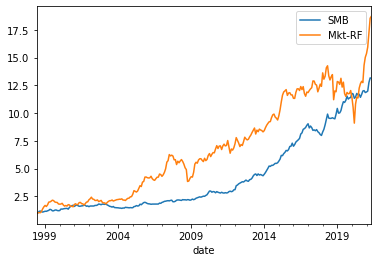

In [78]:
(SMB['SMB']/100 + 1).cumprod().plot()
(kospi['Mkt-RF']/100 + 1).cumprod().plot()
plt.legend()

## HML 월별 수익률 구하기

#### Size - B/M 포트폴리오
|Size/ BM|Small|Big|
|---|---|---|
|High BM|SH|BH|
|2|SN|BN|
|Low BM|SL|BL|



구하는 식
- HML = (SH + BH)/2 - (SL + BL)/2  

In [79]:
period = period_index[0]

In [80]:
big_bm_data = book_to_market_ratio.loc[idx[period, big_marcap_ticker],:]['BM']
small_bm_data = book_to_market_ratio.loc[idx[period, small_marcap_ticker],:]['BM']

### B/M에 따라 3분위수로 나눈다.

In [81]:
big_bm_quantile = pd.qcut(big_bm_data, q=3, labels=['BL', 'BN', 'BH']).to_frame()

In [82]:
small_bm_quantile = pd.qcut(small_bm_data, q=3, labels=['SL', 'SN', 'SH']).to_frame()

In [83]:
bh_ticker = big_bm_quantile[big_bm_quantile['BM'].astype(str) == 'BH'].index.get_level_values('ticker')
sh_ticker = small_bm_quantile[small_bm_quantile['BM'].astype(str) == 'SH'].index.get_level_values('ticker')

In [84]:
bl_ticker = big_bm_quantile[big_bm_quantile['BM'].astype(str) == 'BL'].index.get_level_values('ticker')
sl_ticker = small_bm_quantile[small_bm_quantile['BM'].astype(str) == 'SL'].index.get_level_values('ticker')

In [85]:
hml = (get_year_return(period, bh_ticker) + get_year_return(period, sh_ticker))/2 - (get_year_return(period, bl_ticker) + get_year_return(period, sl_ticker))/2

### 전체 기간의 HML을 구해본다.

In [86]:
hml_list = []
def calculate_return(period):
    print(period)
    big_bm_data = book_to_market_ratio.loc[idx[period, big_marcap_ticker],:]['BM']
    small_bm_data = book_to_market_ratio.loc[idx[period, small_marcap_ticker],:]['BM']
    
    # 3분위수로 나눈다.
    big_bm_quantile = pd.qcut(big_bm_data, q=3, labels=['BL', 'BN', 'BH']).to_frame()
    small_bm_quantile = pd.qcut(small_bm_data, q=3, labels=['SL', 'SN', 'SH']).to_frame()
    
    bh_ticker = big_bm_quantile[big_bm_quantile['BM'].astype(str) == 'BH'].index.get_level_values('ticker')
    sh_ticker = small_bm_quantile[small_bm_quantile['BM'].astype(str) == 'SH'].index.get_level_values('ticker')
    
    bl_ticker = big_bm_quantile[big_bm_quantile['BM'].astype(str) == 'BL'].index.get_level_values('ticker')
    sl_ticker = small_bm_quantile[small_bm_quantile['BM'].astype(str) == 'SL'].index.get_level_values('ticker')
    
    hml = (get_year_return(period, bh_ticker) + get_year_return(period, sh_ticker))/2 - (get_year_return(period, bl_ticker) + get_year_return(period, sl_ticker))/2
    hml = hml.to_frame()
    hml.columns = ['HML']
    hml_list.append(hml)
    
for period in period_index:
    hml_list.append(calculate_return(period))

1998-06
1999-06
2000-06
2001-06
2002-06
2003-06
2004-06
2005-06
2006-06
2007-06
2008-06
2009-06
2010-06
2011-06
2012-06
2013-06
2014-06
2015-06
2016-06
2017-06
2018-06
2019-06
2020-06
2021-06


In [87]:
HML = pd.concat(hml_list).sort_index()

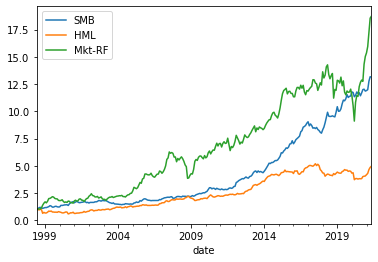

In [88]:
(SMB['SMB']/100 + 1).cumprod().plot()
(HML['HML']/100 + 1).cumprod().plot()
(kospi['Mkt-RF']/100 + 1).cumprod().plot()
plt.legend()

## RMW 월별 수익률 구하기¶

#### Size - OP 포트폴리오
|Size/ OP|Small|Big|
|---|---|---|
|High OP|SR|BR|
|2|SN|BN|
|Low OP|SW|BW|


구하는 식
- RMW = (SR + BR)/2 - (SW + BW)/2  

### 구하는 식의 HML이랑 비슷하므로 바로 코드로 넘어간다.

In [89]:
rmw_list = []

def calculate_return(period):
    print(period)
    big_op_data = op.loc[idx[period, big_marcap_ticker],:]['OP']
    small_op_data = op.loc[idx[period, small_marcap_ticker],:]['OP']
    
    # 3분위수로 나눈다.
    big_op_quantile = pd.qcut(big_op_data, q=3, labels=['BW', 'BN', 'BR']).to_frame()
    small_op_quantile = pd.qcut(small_op_data, q=3, labels=['SW', 'SN', 'SR']).to_frame()
    
    br_ticker = big_op_quantile[big_op_quantile['OP'].astype(str) == 'BR'].index.get_level_values('ticker')
    sr_ticker = small_op_quantile[small_op_quantile['OP'].astype(str) == 'SR'].index.get_level_values('ticker')
    
    bw_ticker = big_op_quantile[big_op_quantile['OP'].astype(str) == 'BW'].index.get_level_values('ticker')
    sw_ticker = small_op_quantile[small_op_quantile['OP'].astype(str) == 'SW'].index.get_level_values('ticker')
    
    rmw = (get_year_return(period, br_ticker) + get_year_return(period, sr_ticker))/2 - (get_year_return(period, bw_ticker) + get_year_return(period, sw_ticker))/2
    rmw = rmw.to_frame()
    rmw.columns = ['RMW']
    return rmw 

for period in period_index:
    rmw_list.append(calculate_return(period))

1998-06
1999-06
2000-06
2001-06
2002-06
2003-06
2004-06
2005-06
2006-06
2007-06
2008-06
2009-06
2010-06
2011-06
2012-06
2013-06
2014-06
2015-06
2016-06
2017-06
2018-06
2019-06
2020-06
2021-06


In [90]:
RMW = pd.concat(rmw_list).sort_index()

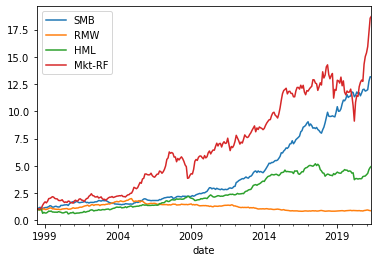

In [91]:
(SMB['SMB']/100 + 1).cumprod().plot()
(RMW['RMW']/100 + 1).cumprod().plot()
(HML['HML']/100 + 1).cumprod().plot()
(kospi['Mkt-RF']/100 + 1).cumprod().plot()
plt.legend()

## CMA 월별 수익률 구하기

#### Size - Inv 포트폴리오
|Size/ Inv|Small|Big|
|---|---|---|
|High Inv|SC|BC|
|2|SN|BN|
|Low Inv|SA|BA|

구하는 식
- CMA = (SC + BC)/2 - (SM + BM)/2  

### 구하는 식의 HML이랑 비슷하므로 바로 코드로 넘어간다.

In [92]:
cma_list = []

def calculate_return(period):
    print(period)
    big_inv_data = inv.loc[idx[period, big_marcap_ticker],:]['INV']
    small_inv_data = inv.loc[idx[period, small_marcap_ticker],:]['INV']
    
    # 3분위수로 나눈다.
    big_inv_quantile = pd.qcut(big_inv_data, q=3, labels=['BA', 'BN', 'BC']).to_frame()
    small_inv_quantile = pd.qcut(small_inv_data, q=3, labels=['SA', 'SN', 'SC']).to_frame()
    
    bc_ticker = big_inv_quantile[big_inv_quantile['INV'].astype(str) == 'BC'].index.get_level_values('ticker')
    sc_ticker = small_inv_quantile[small_inv_quantile['INV'].astype(str) == 'SC'].index.get_level_values('ticker')
    
    ba_ticker = big_inv_quantile[big_inv_quantile['INV'].astype(str) == 'BA'].index.get_level_values('ticker')
    sa_ticker = small_inv_quantile[small_inv_quantile['INV'].astype(str) == 'SA'].index.get_level_values('ticker')
    
    cma = (get_year_return(period, bc_ticker) + get_year_return(period, sc_ticker))/2 - (get_year_return(period, ba_ticker) + get_year_return(period, sa_ticker))/2
    cma = cma.to_frame()
    cma.columns = ['CMA']
    return cma

for period in period_index:
    cma_list.append(calculate_return(period))

1998-06
1999-06
2000-06
2001-06
2002-06
2003-06
2004-06
2005-06
2006-06
2007-06
2008-06
2009-06
2010-06
2011-06
2012-06
2013-06
2014-06
2015-06
2016-06
2017-06
2018-06
2019-06
2020-06
2021-06


In [93]:
CMA = pd.concat(cma_list).sort_index()

## 국내 Equal Weight Fama - French 5요인 수익률

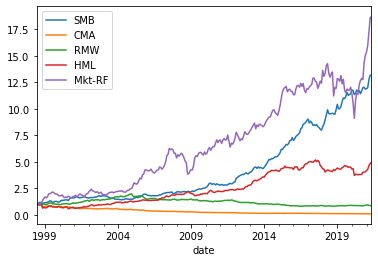

In [94]:
(SMB['SMB']/100 + 1).cumprod().plot()
(CMA['CMA']/100 + 1).cumprod().plot()
(RMW['RMW']/100 + 1).cumprod().plot()
(HML['HML']/100 + 1).cumprod().plot()
(kospi['Mkt-RF']/100 + 1).cumprod().plot()
plt.legend()

In [95]:
CMA

,CMA
date,
1998-07,-0.155998
1998-08,-3.729661
1998-09,0.004001
1998-10,3.265335
1998-11,-28.631149
...,...
2021-01,-0.481857
2021-02,-0.226829
2021-03,-8.503051


In [96]:
fama_french_5_factor_korea = pd.concat([kospi, SMB, HML, RMW, CMA], axis=1).dropna()

In [97]:
fama_french_5_factor_korea

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
1998-07,11.842538,0.481735,1.146705,4.741896,-0.155998
1998-08,0.903730,14.101973,-7.322806,-10.299586,-3.729661
1998-09,-1.216550,2.931755,6.739728,-0.027113,0.004001
1998-10,10.092479,-3.753220,-2.790162,4.685003,3.265335
1998-11,21.841657,-4.391560,-35.507899,-1.628143,-28.631149
...,...,...,...,...,...
2021-01,2.238184,0.414898,2.874167,3.067176,-0.481857
2021-02,3.806827,0.671351,2.906359,1.219407,-0.226829
2021-03,7.911433,6.506479,8.213590,-4.158841,-8.503051


## Risk Free Rate 추가

In [98]:
# 1년 만기 국채 수익률 이용
risk_free_rate = fdr.DataReader('KR1YT=RR')

In [99]:
risk_free = risk_free_rate.resample('M').last()[['Change']]

In [100]:
risk_free = risk_free.rename(columns={'Change':'RF'})
risk_free.index = risk_free.index.to_period()
risk_free.index.name = 'date'

In [101]:
risk_free.head()

,RF
date,
1995-05,0.0000
1995-06,0.0068
1995-07,0.0036
1995-08,0.0000
1995-09,0.0000


## Risk Free Rate 추가

In [102]:
fama_french_5_factor_korea = fama_french_5_factor_korea.join(risk_free)

## Fama - French 5요인 저장

In [103]:
DATA_STORE = Path('assets.h5')

In [104]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('fama_french/equal_weight/korea', fama_french_5_factor_korea)

## 미국 Fama - French 5요인 비교

In [105]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = pdr.DataReader(ff_factor, 'famafrench', start='1995')[0]

In [106]:
ff_factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1995-01,1.80,-3.11,2.54,0.09,-0.83,0.42
1995-02,3.63,-0.52,1.12,0.61,-0.33,0.40
1995-03,2.19,-0.51,-2.15,-0.09,0.16,0.46
1995-04,2.11,-0.29,1.71,0.24,1.00,0.44
1995-05,2.90,-2.20,2.23,0.37,0.09,0.54
...,...,...,...,...,...,...
2021-01,-0.03,6.88,2.85,-3.33,4.68,0.00
2021-02,2.78,4.51,7.08,0.09,-1.97,0.00
2021-03,3.08,-0.97,7.40,6.43,3.44,0.00


## 미국 5요인과 국내 5요인과 수익률 비교

<AxesSubplot:xlabel='Date'>

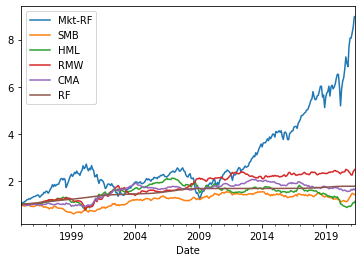

In [107]:
(ff_factor_data/100 + 1).cumprod().plot()

<AxesSubplot:xlabel='date'>

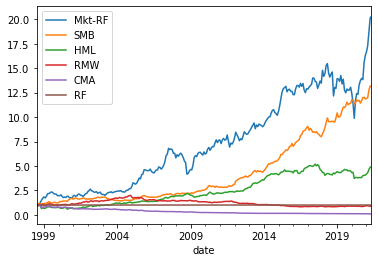

In [108]:
(fama_french_5_factor_korea/100 + 1).cumprod().plot()

In [109]:
fama_french_5_factor_korea.corr()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,1.000000,-0.028746,-0.183287,-0.019361,-0.182259,0.104665
SMB,-0.028746,1.000000,0.325072,-0.202775,-0.065172,-0.050146
HML,-0.183287,0.325072,1.000000,0.326673,0.427261,0.034296
RMW,-0.019361,-0.202775,0.326673,1.000000,0.432327,0.005243
CMA,-0.182259,-0.065172,0.427261,0.432327,1.000000,0.026790
RF,0.104665,-0.050146,0.034296,0.005243,0.026790,1.000000


In [110]:
fama_french_5_factor_korea.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,1.236744,0.984802,0.704483,-0.013346,-0.808767,0.000363
std,5.238973,3.003052,4.729552,2.914485,3.146677,0.015221
min,-21.786403,-7.474589,-35.507899,-10.524656,-28.631149,-0.056600
25%,-1.690543,-0.875360,-0.840052,-1.642012,-2.211078,-0.005050
50%,1.094318,0.919895,0.851198,0.233739,-0.567571,0.000000
75%,3.773020,2.906032,2.755747,1.722634,0.923586,0.002450
max,21.841657,14.101973,14.987152,12.767386,12.881358,0.119400


## 결론
- 기존의 미국 fama french 5요인을 보면 한국 Fama French와는 많이 다른것을 알 수 있다.


## 이유
- 이유는 미국 Fama - French 5요인 데이터는 value weight portfolio로 구성했고 국내 Fama - French는 equal weight portfolio로 구성했으므로 전자보다 시가총액이 작은 주식의 영향력이 커저서 그렇다.

## 추가할 사항
- Value Weight Fama - French 5 Factor 

## Value Weight Fama - French Portfolio 생성

### marcap 데이터 가져오기

In [111]:
def convert_datetime_index_to_period_index(data: pd.DataFrame):
    return data.index.set_levels(data.index.levels[0].to_period('M'), level=0)

In [112]:
monthly_marcap = size_factor[['adj_marcap']].unstack('ticker').resample('M').last().stack('ticker')

In [113]:
monthly_marcap.index = convert_datetime_index_to_period_index(monthly_marcap)

In [114]:
def get_value_weight_return(period, ticker_range):
    data = get_year_base(period, ticker_range).fillna(method='bfill')
    ticker_range = data.columns.get_level_values('ticker')
    period_range = data.index
    marcap = monthly_marcap.loc[idx[period_range, ticker_range], :].unstack().fillna(method='bfill')
    marcap_ratio = marcap / marcap.sum(axis=1).to_numpy().reshape(-1, 1)
    value_weight_return = data['return'] * marcap_ratio['adj_marcap']
    return value_weight_return.sum(axis=1)
#     return marcap_ratio